In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_CoM_continuous
%store -r Y_motion_CoM_continuous
print(X_motion_CoM_continuous.shape)
print(Y_motion_CoM_continuous.shape)

(10027, 28)
(10027, 2)


In [6]:
X_motion_CoM_continuous[0]

array([0.10000000149011612, 0.0, 0.0, 0.06422444087825316,
       0.12709958334894797, 0.02129841568653252, 0.032841687967686085,
       0.007458737822045343, -0.018058522863240344, 0.2349003268785842,
       0.18683081039427935, -0.40515855604189455, 0.23261810624015347,
       -0.20303246525516214, -0.4050806504096208, -0.26129141850751325,
       0.13343324739617787, -0.40023590712089907, -0.2499161232198911,
       -0.15232611895506265, -0.4005353553555561, False, True, True,
       False, 0.10000000149011612, 0.0, 0.0], dtype=object)

In [7]:
Y_motion_CoM_continuous[0]

array([0.017403092379263185, -0.02304735349003534], dtype=object)

# Multivariate Linear Regression (CoM Prediction)

In [8]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [9]:
idx_fr_rl_swinging = np.where(X_motion_CoM_continuous[:, 22] == 1)[0]
X_motion_CoM_continuous_FR_RL = X_motion_CoM_continuous[idx_fr_rl_swinging]
Y_motion_CoM_continuous_FR_RL = Y_motion_CoM_continuous[idx_fr_rl_swinging]
print(X_motion_CoM_continuous_FR_RL.shape)
print(Y_motion_CoM_continuous_FR_RL.shape)

(5022, 28)
(5022, 2)


## Predict CoM (x) movement

In [10]:
X_motion_CoM_continuous_FR_RL[0, :]

array([0.10000000149011612, 0.0, 0.0, 0.06422444087825316,
       0.12709958334894797, 0.02129841568653252, 0.032841687967686085,
       0.007458737822045343, -0.018058522863240344, 0.2349003268785842,
       0.18683081039427935, -0.40515855604189455, 0.23261810624015347,
       -0.20303246525516214, -0.4050806504096208, -0.26129141850751325,
       0.13343324739617787, -0.40023590712089907, -0.2499161232198911,
       -0.15232611895506265, -0.4005353553555561, False, True, True,
       False, 0.10000000149011612, 0.0, 0.0], dtype=object)

In [11]:
Y_motion_CoM_continuous_FR_RL[0, :]

array([0.017403092379263185, -0.02304735349003534], dtype=object)

### Linear Regression

In [19]:
# Input
X = np.hstack((X_motion_CoM_continuous_FR_RL[:, :3], # motion command
               X_motion_CoM_continuous_FR_RL[:, 9:11], # FL (x,y) position
               X_motion_CoM_continuous_FR_RL[:, 12:14], # FR (x,y) position
               X_motion_CoM_continuous_FR_RL[:, 15:17], # RL (x,y) position
               X_motion_CoM_continuous_FR_RL[:, 18:20])) # RR (x,y) position
               
# Labels
Y = np.array([Y_motion_CoM_continuous_FR_RL[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True)

# Create the model
model_fr_com_x = LinearRegression()

# Fit the model
model_fr_com_x.fit(X_train, Y_train)

# Predict
predictions = model_fr_com_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.998011853047272
RMSE:  0.0018586124073727416
The lowest error is:  1.989335382771018e-06
The highest error is:  0.017721449408000176
The avg. error is:  0.0012341442410231274


In [23]:
model_fr_com_x.coef_

array([[ 0.17536781, -0.04131492,  0.00218651, -0.07236059,  0.2668249 ,
         0.22290188, -0.02830222,  0.23198114,  0.05932601,  0.07712831,
         0.1316227 ]])

In [24]:
model_fr_com_x.intercept_

array([0.00154903])

Text(0, 0.5, 'Predictions')

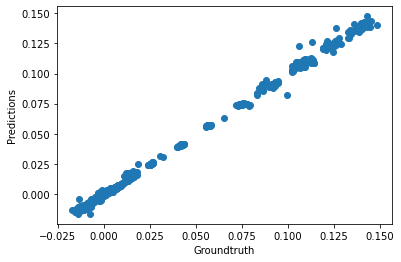

In [25]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [26]:
#%store model_fr_com_x

In [27]:
#for idx, prediction in enumerate(predictions):
#    print(f'Command: {X_test[idx, :3]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [28]:
# Save model
#joblib.dump(model_fr_com_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fr_com_x.sav")

## Predict CoM -> y

### Linear Regression

In [30]:
# Input
X = np.hstack((X_motion_CoM_continuous_FR_RL[:, :3], # motion command
               X_motion_CoM_continuous_FR_RL[:, 9:11], # FL (x,y) position
               X_motion_CoM_continuous_FR_RL[:, 12:14], # FR (x,y) position
               X_motion_CoM_continuous_FR_RL[:, 15:17], # RL (x,y) position
               X_motion_CoM_continuous_FR_RL[:, 18:20])) # RR (x,y) position

# Labels
Y = np.array([Y_motion_CoM_continuous_FR_RL[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True)

# Create the model
model_fr_com_y = LinearRegression()

# Fit the model
model_fr_com_y.fit(X_train, Y_train)

# Predict
predictions = model_fr_com_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.996154351267241
RMSE:  0.002074022196708177
The lowest error is:  1.2276156432060314e-06
The highest error is:  0.015782292556486513
The avg. error is:  0.00135765219350503


In [31]:
model_fr_com_y.coef_

array([[-0.04572257,  0.20068902,  0.01017332,  0.30552661, -0.15529948,
         0.0836753 ,  0.25474342,  0.00997837,  0.15795191,  0.22584636,
        -0.03101185]])

In [32]:
model_fr_com_y.intercept_

array([0.00458742])

Text(0, 0.5, 'Predictions')

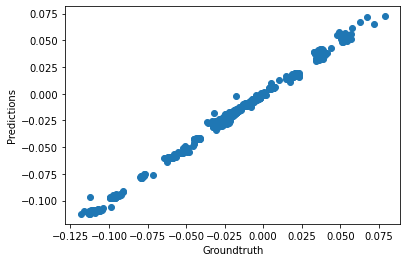

In [33]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [47]:
#%store model_fr_com_y

In [48]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [29]:
# Save model
#joblib.dump(model_fr_com_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fr_com_y.sav")